# Linear Regression

Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar  # we may want to account for holidays and this would allow that
import datetime
from dateutil.parser import parse
import os

In [2]:
#------------------------------------------------------------------------
# CLEAN AND READ DATA
#------------------------------------------------------------------------
clean_data = False
base_directory = "A:/"
if clean_data:
    directory = os.fsencode(base_directory + "original")

    current_time = datetime.datetime.now()

    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        print("Reading " + filename + "...")
        _input = pd.read_excel(base_directory + "original/" + filename, thousands=',')

        # filter bad input
        mask = (_input["End Time"] != "-") & (_input["Miles"] > 1) 
        _input = _input[mask]

        # filter bad dates
        _input["End Time"] = pd.to_datetime(_input["End Time"]) 
        _input["Shipment Date"] = pd.to_datetime(_input["Shipment Date"])
        mask = (_input["End Time"] >= _input["Shipment Date"]) & (_input["End Time"] <= current_time)
        _input = _input[mask]

        # filter to match maximum delivery time for different modes
        # mask = ((((_input["End Time"] - _input["Shipment Date"]).astype('timedelta64[D]').astype('int32') <= 30) and (_input["Mode"] == "RAIL")) | 
        #        (((_input["End Time"] - _input["Shipment Date"]).astype('timedelta64[D]').astype('int32') <= 8) and (_input["Mode"] == "TL")) | 
        #        (((_input["End Time"] - _input["Shipment Date"]).astype('timedelta64[D]').astype('int32') <= 22) and (_input["Mode"] == "IM")))
        #_input = _input[mask]
        
        _input.reindex()

        # create clean df
        delta = pd.Series(_input["End Time"] - _input["Shipment Date"])
        delta = delta.astype('timedelta64[D]').astype('int32') # convert time to int
        month = pd.Categorical(list(map(lambda x:x.month, _input["Shipment Date"])))
        day = pd.Categorical(list(map(lambda x:x.day, _input["Shipment Date"])))
        weekday = pd.Categorical(list(map(lambda x:x.weekday(), _input["Shipment Date"])))

        training = pd.DataFrame({
            'month' : month,
            'day' : day,
            'weekday' : weekday,
            'm_sys' : _input["Source System"],
            'mode' : _input["Mode"],
            'segment' : _input["Division"],
            'direction' : _input["Direction"],
            'dist' : _input["Miles"],
            'weight' : _input["Weight Tons"],
            'delta' : delta})

        print("Writing to " + filename + ".csv...")
        training.to_csv(base_directory + 'csv/' + filename + '.csv', index=False)



In [3]:
directory = os.fsencode(base_directory + "csv")

training = pd.DataFrame()
for file in os.listdir(directory): # append data to df
    filename = os.fsdecode(file)
    print("Reading " + filename + "...")
    temp = pd.read_csv(base_directory + "csv/" + filename, thousands=',')
    training = pd.concat([training, temp], sort=True)
    
training.reset_index(inplace=True)

Reading 19-01.xlsx.csv...
Reading 18-07.xlsx.csv...
Reading 19-02.xlsx.csv...
Reading 19-03.xlsx.csv...
Reading 18-05.xlsx.csv...
Reading 19-11.xlsx.csv...
Reading 18-08.xlsx.csv...
Reading 19-04.xlsx.csv...
Reading 19-05.xlsx.csv...
Reading 18-11.xlsx.csv...
Reading 19-06.xlsx.csv...
Reading 18-06.xlsx.csv...
Reading 18-10.xlsx.csv...
Reading 19-08.xlsx.csv...
Reading 18-03.xlsx.csv...
Reading 19-07.xlsx.csv...
Reading 18-12.xlsx.csv...
Reading 18-09.xlsx.csv...
Reading 18-02.xlsx.csv...
Reading 18-01.xlsx.csv...
Reading 19-10.xlsx.csv...
Reading 17-09.xlsx.csv...
Reading 19-12.xlsx.csv...
Reading 18-04.xlsx.csv...
Reading ._17-09.xlsx.csv...


In [4]:
# convert to catagorical var
#training['day'] = training['day'].astype('category')
training['month'] = training['month'].astype('category')
training['direction'] = training['direction'].astype('category')
training['m_sys'] = training['m_sys'].astype('category')
training['mode'] = training['mode'].astype('category')
training['segment'] = training['segment'].astype('category')
training['weekday'] = training['weekday'].astype('category')

# set x and y
delta = training['delta']
training = training.drop(columns=['delta'])

# make dummy categorical variables for numpy
training_d = pd.get_dummies(training)

All of the data should be read in at this point along with basic set up

Now we insert other variables that might affect the final outcome, such as punishing larger weights/distances more

Then we show the top of the table so we know what we are working with


In [5]:
training_d['weight squared'] = training_d['weight']**2
training_d['distance squared'] = training_d['dist']**2
training_d.head()

,index,day,dist,weight,direction_INBOUND,direction_OUTBOUND,m_sys_OTM,m_sys_TMS-Manhattan,m_sys_Transplace,mode_IM,...,segment_CONTAINERBOARD MILL,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weight squared,distance squared
0,0,26.0,1135.0,75.51,0,1,1,0,0,0,...,1,0,0,0,0,0,1,0,5701.7601,1288225.0
1,1,25.0,1135.0,72.09,0,1,1,0,0,0,...,1,0,0,0,0,1,0,0,5196.9681,1288225.0
2,2,21.0,991.0,151.74,1,0,1,0,0,0,...,1,1,0,0,0,0,0,0,23025.0276,982081.0
3,3,21.0,991.0,123.24,1,0,1,0,0,0,...,1,1,0,0,0,0,0,0,15188.0976,982081.0
4,4,21.0,991.0,225.90,1,0,1,0,0,0,...,1,1,0,0,0,0,0,0,51030.8100,982081.0


In [6]:
training_d.dropna(axis=0, how='any', inplace=True)

# column_names = ['day', 'month', 'direction', 'm_sys', 'mode', 'segment', 'dist', 'weight', 'weight squared', 'distance squared']

X = training_d.drop(columns=['index'])
Y = delta

X.head()

,day,dist,weight,direction_INBOUND,direction_OUTBOUND,m_sys_OTM,m_sys_TMS-Manhattan,m_sys_Transplace,mode_IM,mode_LTL,...,segment_CONTAINERBOARD MILL,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weight squared,distance squared
0,26.0,1135.0,75.51,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,5701.7601,1288225.0
1,25.0,1135.0,72.09,0,1,1,0,0,0,0,...,1,0,0,0,0,1,0,0,5196.9681,1288225.0
2,21.0,991.0,151.74,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,23025.0276,982081.0
3,21.0,991.0,123.24,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,15188.0976,982081.0
4,21.0,991.0,225.90,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,51030.8100,982081.0


In [7]:
#------------------------------------------------------------------------
# LIN REG MODEL
#------------------------------------------------------------------------

model = LinearRegression()
kfold = KFold(n_splits=5, shuffle=True)
scores = []
#MSE = []
#MAE = []
for result in kfold.split(X, Y):
    model.fit(X.iloc[result[0]], Y.iloc[result[0]])
    score = model.score(X.iloc[result[1]], Y.iloc[result[1]])
    scores.append(score)
    #MSE.append(metrics.mean_squared_error(Y.iloc[result[1]], X.iloc[result[1]]))

# r-values (not great)
print(scores)


[0.32032219430624054, 0.3487128616991775, 0.34552703586358446, 0.3280191705505786, 0.36201863554331515]


In [8]:
# model = LinearRegression()
# model.fit(X, Y)
training_d['predicted'] = model.predict(X)

training_d['predicted_rounded'] = np.round(training_d['predicted'])
print(training_d['predicted_rounded'])

0         14.0
1         14.0
2         21.0
3         17.0
4         34.0
5         20.0
6         11.0
7         12.0
8         12.0
9         16.0
10        15.0
11        14.0
12        14.0
13        11.0
14        12.0
15        12.0
16        17.0
17        14.0
18        13.0
19        14.0
20        14.0
21        12.0
22        15.0
23        15.0
24        11.0
25        13.0
26        12.0
27        12.0
28        12.0
29        12.0
          ... 
962717    17.0
962718    13.0
962719    14.0
962720    13.0
962721    13.0
962722     2.0
962723    16.0
962724     0.0
962725     5.0
962726    11.0
962727    -0.0
962728    -0.0
962729    -0.0
962730    -0.0
962731    -0.0
962732    -0.0
962733    -0.0
962734    -0.0
962735     0.0
962736     0.0
962737     0.0
962738    -0.0
962739    14.0
962740    14.0
962741    14.0
962742    14.0
962743    16.0
962744     6.0
962745     7.0
962746     2.0
Name: predicted_rounded, Length: 962747, dtype: float64


In [9]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, Y)).coef_
              for i in range(10)], 0)

In [10]:
params = pd.Series(model.coef_, index=X.columns)


Finally, we can compare the total and predicted days for delivery visually:

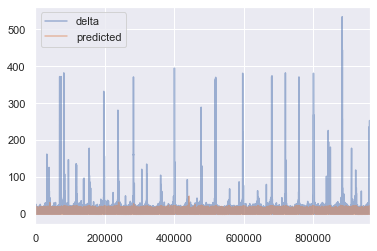

In [11]:
training_d['delta'] = delta
training_d[['delta', 'predicted']].plot(alpha=0.5)

We removed the dates that are in the future so that we can have a more accurate representation of the data. There are still some very long delivery days that the model doesn't predict.

Finally, we print out the standard metrics so we can see how each variable affects the outcome as well as what the Mean Squared Error is.

In [12]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(training_d['delta'], training_d['predicted']))  
print('Mean Squared Error:', metrics.mean_squared_error(training_d['delta'], training_d['predicted']))  
print('\n')

print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))


Mean Absolute Error: 2.0560281091007426
Mean Squared Error: 35.323525202303806


                             effect  error
day                            -0.0    0.0
dist                            0.0    0.0
weight                         -0.0    0.0
direction_INBOUND               0.0    0.0
direction_OUTBOUND             -0.0    0.0
m_sys_OTM                      -0.0    0.0
m_sys_TMS-Manhattan             2.0    0.0
m_sys_Transplace               -1.0    0.0
mode_IM                         1.0    0.0
mode_LTL                       -2.0    0.0
mode_RAIL                       5.0    0.0
mode_TL                        -3.0    0.0
month_1.0                       0.0    0.0
month_2.0                       0.0    0.0
month_3.0                      -0.0    0.0
month_4.0                      -0.0    0.0
month_5.0                      -0.0    0.0
month_6.0                      -0.0    0.0
month_7.0                      -0.0    0.0
month_8.0                      -0.0    0.0
month_9.0       

Looking at the effects, it appears that the day of the month is playing too large a role in determining the outcome, while we think that it should mostly be useless. We think that the day of the week should be used instead of the day of the month to more accurately represent longer or shorter delivery times.


Code to compare _delta_ and _predicted_ to see if we are within the target 25%

Also prints the number of days where we are within the target goal.

In [18]:
# percent_wrong = abs(training_d['delta'] - training_d['predicted_rounded'])/(training_d['delta'])

# percent_wrong_array = np.asarray(percent_wrong)
# count_within_range = (percent_wrong_array < 0.25).sum()

# count_within_range = len(np.where(percent_wrong<0.25))
# print(count_within_range)
# print(count_within_range/len(percent_wrong)*100)

In [19]:
percent_wrong = abs(training_d['delta'] - training_d['predicted'])/(training_d['delta'])

percent_wrong_array = np.asarray(percent_wrong)
count_within_range = (percent_wrong_array < 0.25).sum()

# count_within_range = len(np.where(percent_wrong<0.25))
print(count_within_range)
print(count_within_range/len(percent_wrong)*100)

204482
21.239432581976367


Try sorting percent_wrong and grabbing the 80% item to get a view of how accurate everything is.

In [15]:
print(np.mean(training_d['delta']))
print(np.min(training_d['delta']))
print(np.max(training_d['delta']))
print(np.median(training_d['delta']))

3.8121043223193634
0.0
534.0
1.0


In [16]:
print(np.percentile(percent_wrong, 21))

print(np.median(training_d['predicted']))

0.2468749480745113
1.9065526483309587
